In [2]:
import sys
import os
import inspect
# 添加当前文件夹到 Python 搜索路径
sys.path.insert(0, os.path.abspath("."))
import segment_anything
from segment_anything import sam_model_registry, SamPredictor
import torch.nn as nn
import torch
import argparse
from torch import optim
from torch.utils.data import DataLoader
from DataLoader import TrainingDataset, stack_dict_batched
from torch.utils.data import ConcatDataset
from utils import FocalDiceloss_IoULoss, get_logger, generate_point, setting_prompt_none
from metrics import SegMetrics
import time
from tqdm import tqdm
import numpy as np
import datetime
from torch.nn import functional as F

from apex import amp
import random
import json
from pathlib import Path
import wandb
import glob
from tensorboardX import SummaryWriter
from utils import *


def parse_args():
    parser = argparse.ArgumentParser()
    
    # 重新训练前进行修改
    parser.add_argument("--work_dir", type=str, default="/root/autodl-tmp/checkpoint/SAM_Med2D_mona_mask1", help="work dir")
    parser.add_argument("--run_name", type=str, default="sam-cryo", help="run model name")
    
    parser.add_argument("--epochs", type=int, default=100, help="number of epochs")
    parser.add_argument("--batch_size", type=int, default=2, help="train batch size")
    
    parser.add_argument("--num_workers", type=int, default=16, help="train num_workers")
    parser.add_argument("--image_size", type=int, default=1024, help="image_size")
    
    
    parser.add_argument("--point_num", type=int, default=50, help="get mask number")
    parser.add_argument("--mask_num", type=int, default=1, help="get mask number")
    
    # parser.add_argument("--data_path", type=str, default="data_demo", help="train data path") 
    parser.add_argument("--train_dataset_path_1", type=str, default="/root/autodl-tmp/datasets/train_dataset/*/val/denoised/*.jpg", help="train data path")
    parser.add_argument("--train_point_path_1", type=str, default="/root/Promptpoint/SFS_pro_Unet/datasets/train_dataset", help="train data path")
    
    parser.add_argument("--train_dataset_path_2", type=str, default="/root/Promptpoint/SAM_Med2D_Mona_mask/half_file_paths_all.txt", help="train data path")
    parser.add_argument("--train_point_path_2", type=str, default="/root/Promptpoint/SFS_pro_Unet/datasets/test_dataset", help="train data path")
    
    parser.add_argument("--test_dataset_path", type=str, default="/root/autodl-tmp/datasets/test_dataset/*/", help="test data path")
    parser.add_argument("--test_point_path", type=str, default="/root/Promptpoint/SFS_pro_Unet/datasets/test_dataset", help="test data path")
    
    parser.add_argument("--metrics", nargs='+', default=['iou', 'dice'], help="metrics")
    parser.add_argument('--device', type=str, default='cuda')
    parser.add_argument("--lr", type=float, default=1e-4, help="learning rate")
    parser.add_argument("--resume", type=str, default=None, help="load resume") 
    parser.add_argument("--model_type", type=str, default="vit_b", help="sam model_type")
    parser.add_argument("--sam_checkpoint", type=str, default="/root/Promptpoint/finetune-SAM/sam_vit_b_01ec64.pth", help="sam checkpoint")
    
    
    # parser.add_argument("--iter_point", type=int, default=8, help="point iterations")
    
    parser.add_argument('--lr_scheduler', type=str, default=None, help='lr scheduler')
    
    
    # parser.add_argument("--point_list", type=list, default=[1, 3, 5, 9], help="point_list")
    
    
    parser.add_argument("--multimask", type=bool, default=True, help="ouput multimask")
    parser.add_argument("--encoder_adapter", type=bool, default=True, help="use adapter")
    parser.add_argument("--use_amp", type=bool, default=False, help="use amp")
  
    # args = parser.parse_args()
    args = parser.parse_args(args=[])
    if args.resume is not None:
        args.sam_checkpoint = None
    return args

/root/miniconda3/envs/cryosegnet/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/root/miniconda3/envs/cryosegnet/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.7 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
args = parse_args()
train_image_path_1 = list(glob.glob(args.train_dataset_path_1))
train_dataset_1 = TrainingDataset(args, train_image_path_1, point_path=args.train_point_path_1,image_size=args.image_size, mode='train', point_num=args.point_num, mask_num=args.mask_num, requires_name = True)
print("Training dataset size: ", len(train_dataset_1))
# txt
with open(args.train_dataset_path_2, 'r') as f:
    train_image_path_2 = [line.strip() for line in f if line.strip()]
    train_dataset_2 = TrainingDataset(args,train_image_path_2, point_path=args.train_point_path_2,image_size=args.image_size,mode='train',point_num=args.point_num,mask_num=args.mask_num,requires_name=True)
print("Training dataset size: ", len(train_dataset_2))

train_dataset = ConcatDataset([train_dataset_1, train_dataset_2])

train_loader = DataLoader(train_dataset, batch_size = args.batch_size, shuffle=True, num_workers=8)

print("Training dataset size: ", len(train_dataset))


Training dataset size:  712
Training dataset size:  925
Training dataset size:  1637


In [3]:
def stack_dict_batched(batched_input):
    out_dict = {}
    for k,v in batched_input.items():
        if isinstance(v, list):
            out_dict[k] = v
        else:
            out_dict[k] = v.reshape(-1, *v.shape[2:])
    return out_dict
  
# train_batch_sampler = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True, num_workers=4)
for i, batched_image in enumerate(train_loader):
        # batched_image = stack_dict_batched(batched_image)
        print(batched_image["image"].shape, batched_image["label"].shape)
        print(batched_image["point_coords"].shape)
        print(batched_image["point_labels"].shape)
        break

torch.Size([2, 3, 1024, 1024]) torch.Size([2, 1, 1024, 1024])
torch.Size([2, 50, 2])
torch.Size([2, 50])


In [4]:
value=train_dataset[800]
print(value['image'].shape)
print(value['label'].shape)
print(value['pro_mask'].shape)
print(value['point_coords'].shape)
print(value['point_labels'].shape)
print(value['name'])
print(value['pro_mask'].dtype)

torch.Size([3, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([50, 2])
torch.Size([50])
339.jpg
torch.float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor([465.,  98.])


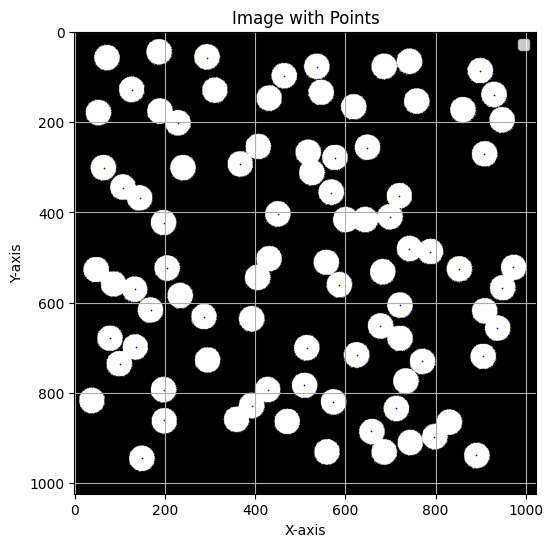

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

mask = value['label']
image_np = mask.numpy()[0]

# 绘制图像
plt.figure(figsize=(6, 6))
plt.imshow(image_np, cmap='gray')

points=value['point_coords']
print(points[0])
# # 标注点
x_coords = [point[0] for point in points]
y_coords = [point[1] for point in points]
plt.scatter(x_coords, y_coords, c='blue', s=5, edgecolor='white')  # 红色点，带白色边框以增强可见性
plt.title("Image with Points")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


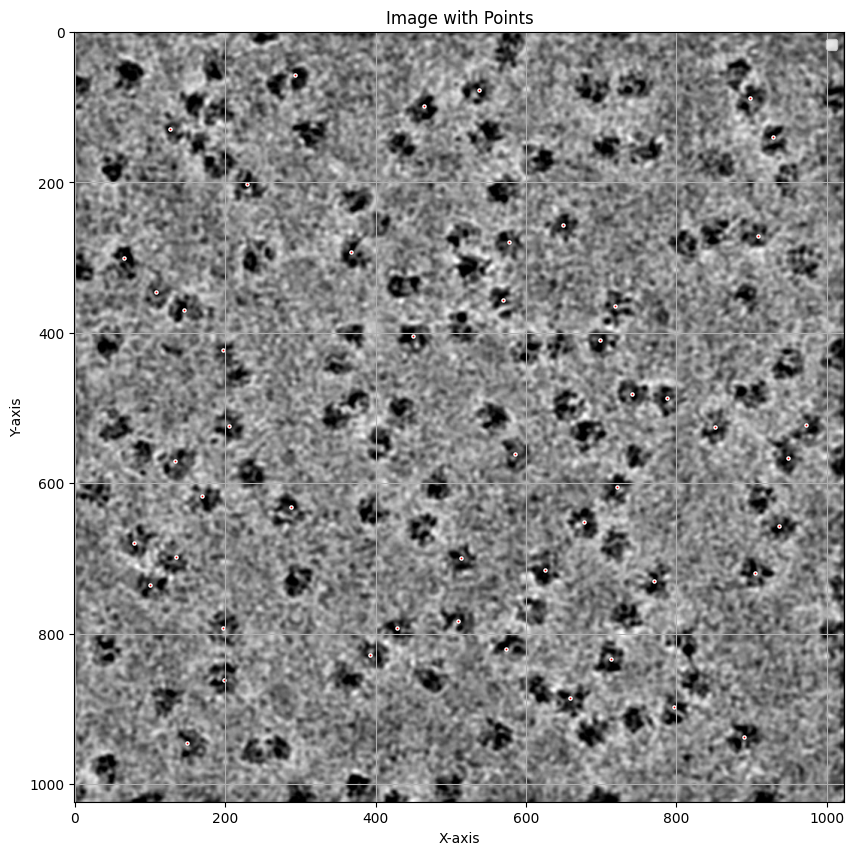

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np

image = value['image']
gray_image = image[0,  :, :]
image_np = gray_image.numpy()

# 绘制图像
plt.figure(figsize=(10, 10))
plt.imshow(image_np, cmap='gray')


points=value['point_coords']
# # 标注点
x_coords = [point[0] for point in points]
y_coords = [point[1] for point in points]
plt.scatter(x_coords, y_coords, c='red', s=5, edgecolor='white')  # 红色点，带白色边框以增强可见性

# points_all=vuale[-1]
# # # 标注点
# x = [point[0] for point in points_all]
# y = [point[1] for point in points_all]
# plt.scatter(x, y, c='blue', s=5, edgecolor='white')  # 红色点，带白色边框以增强可见性


plt.title("Image with Points")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.show()

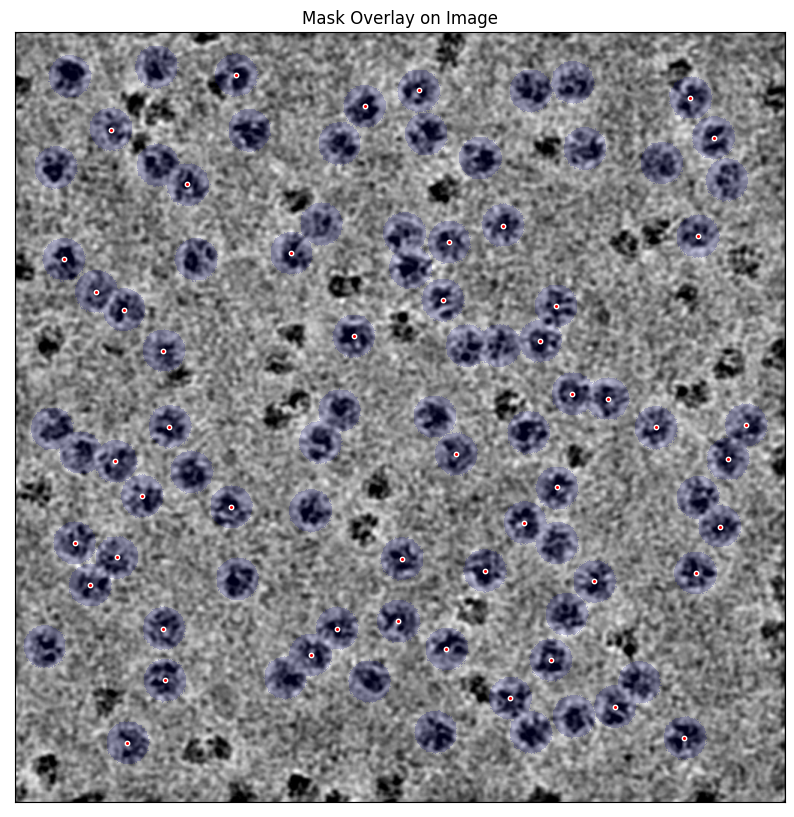

In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 假设 v 是包含数据的变量
image = value['image']  
mask = value['label'][0]
points = value['point_coords'] # 关键点坐标

# 获取灰度图像
gray_image = image[0, :, :].numpy()  # 转换为 numpy 数组

# 提取关键点坐标
x_coords = [point[0] for point in points]
y_coords = [point[1] for point in points]

# 绘制图像
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(gray_image, cmap='gray')  # 原始图像
masked_mask = np.ma.masked_where(mask == 0, mask)
ax.imshow(masked_mask, cmap='jet', alpha=0.2, interpolation='nearest')  # 透明叠加

# 标注关键点
ax.scatter(x_coords, y_coords, c='red', s=10, edgecolors='white')

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Mask Overlay on Image")

# 添加颜色条，仅对 `masked_mask` 生效
# cbar = plt.colorbar(ax.imshow(masked_mask, cmap='jet', alpha=0.5), ax=ax)
# cbar.set_label("Mask Overlap Count")

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor([465.,  98.])


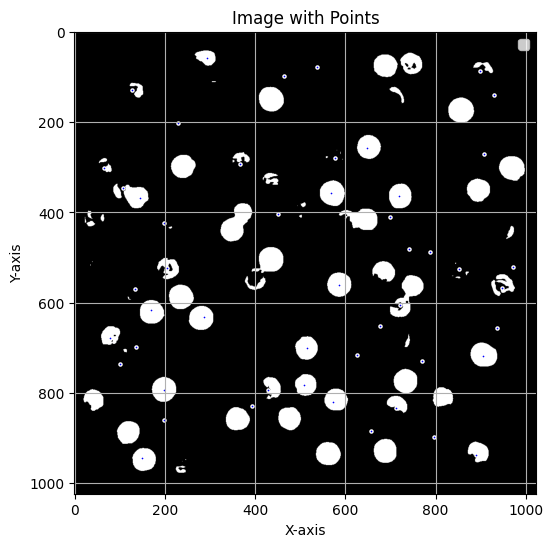

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

mask = value['pro_mask']
image_np = mask.numpy()[0]

# 绘制图像
plt.figure(figsize=(6, 6))
plt.imshow(image_np, cmap='gray')

points=value['point_coords']
print(points[0])
# # 标注点
# # 标注点
x_coords = [point[0] for point in points]
y_coords = [point[1] for point in points]
plt.scatter(x_coords, y_coords, c='blue', s=5, edgecolor='white')  # 红色点，带白色边框以增强可见性
plt.title("Image with Points")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.show()

In [2]:
from skimage import io

# 指定图片路径
image_path = "/root/autodl-tmp/result/10028/masks/061_mask.jpg"

# 读取图片
image = io.imread(image_path)

# 获取图片形状
shape = image.shape

# 判断通道数
if len(shape) == 2:  # 只有 (height, width)，说明是灰度图
    channels = 1
elif len(shape) == 3:  # (height, width, channels)
    channels = shape[2]
else:
    channels = "Unknown"

print(f"Image shape: {shape}, Channels: {channels}")

Image shape: (4096, 4096, 3), Channels: 3


In [3]:
import os
import random

# 所有目标文件夹
folder_ids = [ '10017']

# 根路径
root_path = '/root/autodl-tmp/datasets/test_dataset'

# 保存的路径文件
txt_save_path = '10017.txt'

# 打开保存文件
with open(txt_save_path, 'w') as out_file:
    for folder_id in folder_ids:
        folder_path = os.path.join(root_path, folder_id, 'denoised')

        # 获取该文件夹下所有文件的完整路径
        all_files = [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, f))
        ]

        # 打乱并取一半
        random.shuffle(all_files)
        half_files = all_files[:len(all_files) // 2]

        # 写入到 txt 文件
        for file_path in half_files:
            out_file.write(file_path + '\n')

        print(f"{folder_id}: total {len(all_files)}, saved {len(half_files)} to file.")

print(f'\n✅ All selected paths saved to {txt_save_path}')


10017: total 67, saved 67 to file.

✅ All selected paths saved to 10017.txt
